In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score

In [2]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.head()

,demand_MWh
time_index,
2012-01,1.080470e+07
2012-02,1.008555e+07
2012-03,1.017537e+07
2012-04,8.969068e+06
2012-05,9.597272e+06


<AxesSubplot: xlabel='time_index'>

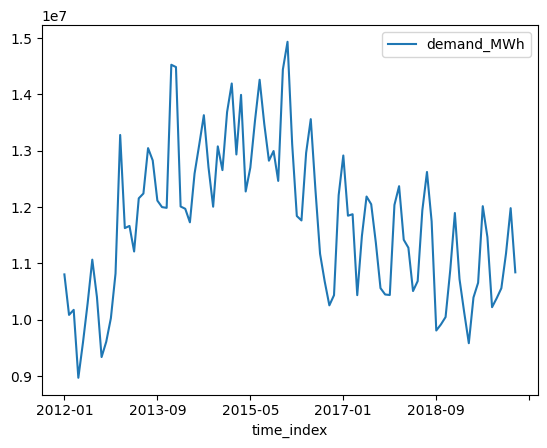

In [3]:
df_time_series.plot()

In [4]:
df_time_series['demand_MWh_shifted'] = df_time_series['demand_MWh'].shift(1)
df_time_series.dropna(inplace=True)

In [5]:
df_time_series.corr()

,demand_MWh,demand_MWh_shifted
demand_MWh,1.000000,0.743123
demand_MWh_shifted,0.743123,1.000000


## Stationarity and ADF Test

In [6]:
result = adfuller(df_time_series[['demand_MWh']])
print(result)
pvalue = result[1]
if pvalue < 0.05:
 print('stationary')
else:
 print('not stationary')

(-1.3228525220472214, 0.6186534962256727, 12, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, 2495.561290403197)
not stationary


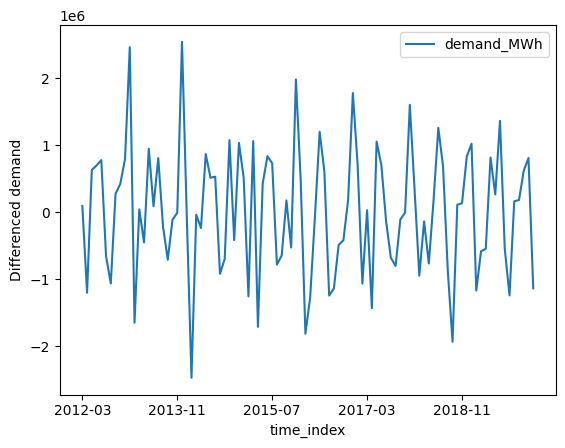

In [7]:
# Difference the data
differenced_data = df_time_series[['demand_MWh']].diff().dropna()
# Plot the differenced data
ax = differenced_data.plot()
ax.set_ylabel('Differenced demand')
plt.show()

In [8]:
differenced_data.shift(1)

,demand_MWh
time_index,
2012-03,NaN
2012-04,89812.774
2012-05,-1206296.596
2012-06,628203.607
2012-07,694910.383
...,...
2019-10,-1245430.320
2019-11,160022.365
2019-12,176879.505


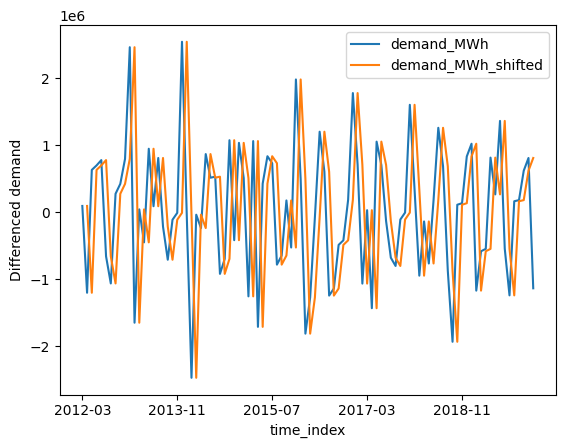

,demand_MWh,demand_MWh_shifted
demand_MWh,1.000000,0.006203
demand_MWh_shifted,0.006203,1.000000


In [9]:
differenced_data['demand_MWh_shifted'] = differenced_data['demand_MWh'].shift(1)
ax = differenced_data.plot()
ax.set_ylabel('Differenced demand')
plt.show()
differenced_data.corr()

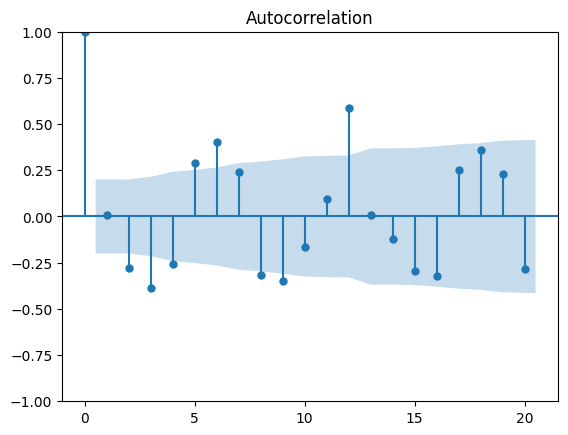

In [10]:
plot_acf(differenced_data['demand_MWh'], lags=20)
plt.show()

/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


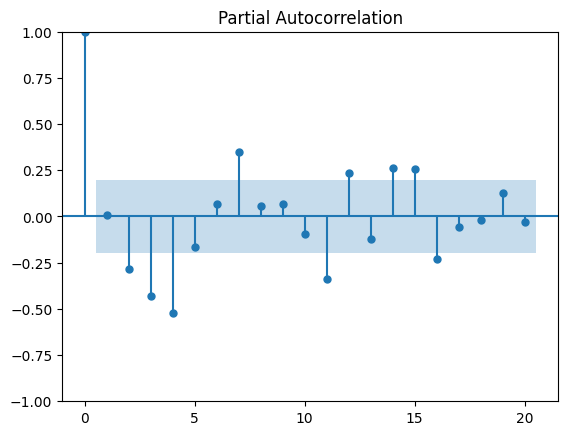

In [11]:
plot_pacf(differenced_data['demand_MWh'], lags = 20)
plt.show()

In [12]:
coefficients, sigma = yule_walker(differenced_data['demand_MWh'], order = 3)
print('coefficients: ', -coefficients)
print('sigma: ', sigma)

coefficients:  [0.11420965 0.27959427 0.4316665 ]
sigma:  828399.6692823435


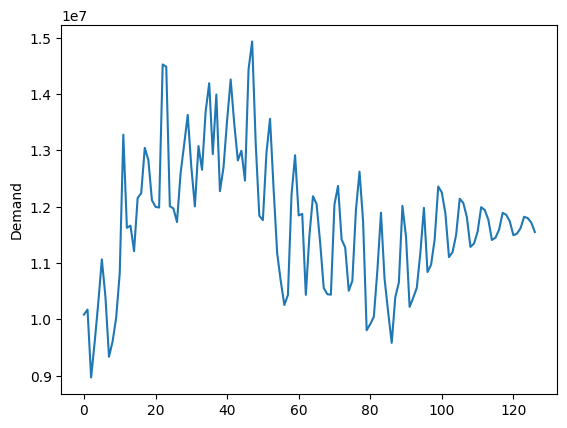

In [13]:
coefficients, sigma = yule_walker(differenced_data['demand_MWh'], order = 3)
# Make a list of differenced values
val_list = list(differenced_data['demand_MWh'])
# Reverse the list so that the order corresponds with the order of the 
coefficients
val_list.reverse()
# Define the number of years to predict
n_steps = 10
# For each year to predict
for i in range(n_steps):
    # Compute the new value as the sum of lagged values multiplied by their corresponding coefficient
    new_val = 0
    for j in range(len(coefficients)):
        new_val += coefficients[j] * val_list[j]
        # Insert the new value at the beginning of the list
        val_list.insert(0, new_val)
# Redo the reverse to have the order of time
val_list.reverse()
# Add the original first value back into the list and do a cumulative sum to undo the differencing
val_list = [df_time_series['demand_MWh'].values[0]] + val_list
new_val_list = pd.Series(val_list).cumsum()
# Plot the newly obtained list
new_val_list
plt.plot(new_val_list)
plt.ylabel('Demand')
plt.show()

original    0
pred        0
dtype: int64
Test R2: -0.8315295987176814


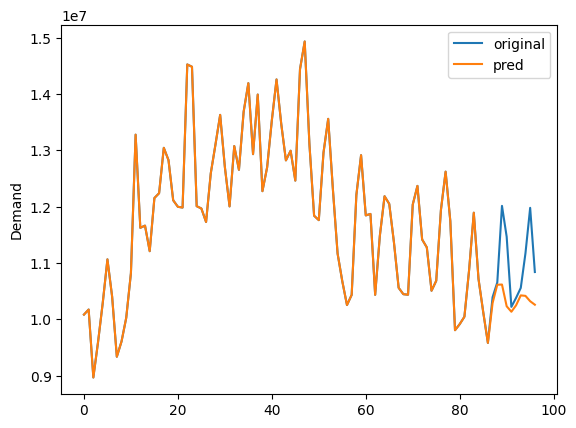

In [27]:
train = list(differenced_data['demand_MWh'])[:-10]
test = list(df_time_series['demand_MWh'])[-10:]
coefficients, sigma = yule_walker(train, order = 3)
# Make a list of differenced values
val_list = list(train)
# Reverse the list so that the order corresponds with the order of the 
coefficients
val_list.reverse()
# Define the number of years to predict
n_steps = 10

# For each year to predict
for i in range(n_steps):
    # Compute the new value as the sum of lagged values multiplied by their corresponding coefficient
    new_val = 0
    for j in range(len(coefficients)):
        new_val += coefficients[j] * val_list[j]
    # Insert the new value at the beginning of the list
    val_list.insert(0, new_val)
# Redo the reverso to have the order of time
val_list.reverse()
# Add the original first value back into the list and do a cumulative sum to undo the differencing
val_list = [df_time_series['demand_MWh'][0]] + val_list
new_val_list = pd.Series(val_list).cumsum()
# Plot the newly obtained list
validation = pd.DataFrame({
 'original': df_time_series['demand_MWh'].reset_index(drop=True),
 'pred': new_val_list })
 
print(validation.isna().sum())
print('Test R2:', r2_score(validation.iloc[-10:, 0], validation.iloc[-10:, 1]))
# Plot the newly obtained list
plt.plot(validation)
plt.legend(validation.columns)
plt.ylabel('Demand')
plt.show()

In [15]:

train = list(differenced_data['demand_MWh'])[:-10]
test = list(df_time_series['demand_MWh'])[-10:]
test

[10394326.915,
 10656712.976,
 12016197.524,
 11468009.022,
 10222578.702,
 10382601.067,
 10559480.572,
 11175324.682,
 11981204.232,
 10841416.806]

In [16]:
df_time_series['demand_MWh'].values[0]

10085552.231

In [26]:
len(list(df_time_series['demand_MWh'])[:-10])

3

In [32]:
def evaluate(order):
    train = list(differenced_data['demand_MWh'])[:-10]
    test = list(df_time_series['demand_MWh'])[-10:]
    coefficients, sigma = yule_walker(train, order = order)
    # Make a list of differenced values
    val_list = list(train)
    # Reverse the list to corresponds with the order of coefs
    val_list.reverse()
    # Define the number of years to predict
    n_steps = 10
    # For each year to predict
    for i in range(n_steps):
        # Compute the new value
        new_val = 0
        for j in range(len(coefficients)):
            new_val += coefficients[j] * val_list[j]
        # Insert the new value at the beginning of the list
        val_list.insert(0, new_val)
        # Redo the reverse to have the order of time
    val_list.reverse()
    # Undo the differencing with a cumsum
    val_list = [df_time_series['demand_MWh'][0]] + val_list
    new_val_list = pd.Series(val_list).cumsum()
    # Plot the newly obtained list
    validation = pd.DataFrame({
        'original': df_time_series['demand_MWh'].reset_index(drop=True),
        'pred': new_val_list })
    return r2_score(validation.iloc[-10:, 0], validation.iloc[-10:, 1])
# For each order between 1 and 30, fit and evaluate the model
orders = []
r2scores = []
for order in range(1, 31):
    orders.append(order)
    r2scores.append(evaluate(order))
# Create a results data frame
results =pd.DataFrame(
    {
        'orders': orders,
        'scores': r2scores
    }
)
# Show the order with best R2 score
results[results['scores'] == results.max()['scores']]

,orders,scores
10,11,0.729303


Test R2: 0.729303092053209


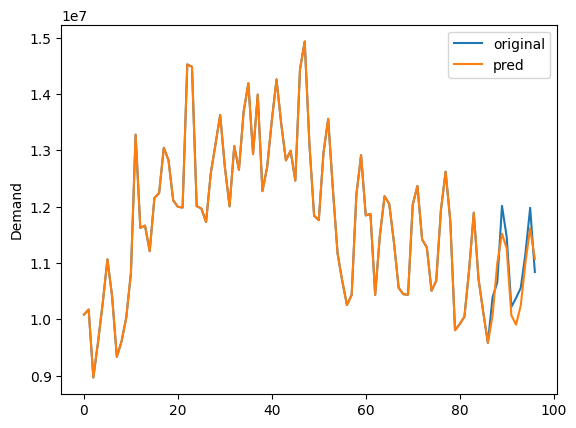

In [43]:
train = list(differenced_data['demand_MWh'])[:-10]
test = list(df_time_series['demand_MWh'])[-10:]
coefficients, sigma = yule_walker(train, order = 11)
# Make a list of differenced values
val_list = list(train)
# Reverse the list so that the order corresponds with the order of the 
coefficients
val_list.reverse()
# Define the number of years to predict
n_steps = 10

# For each year to predict
for i in range(n_steps):
    # Compute the new value as the sum of lagged values multiplied by their corresponding coefficient
    new_val = 0
    for j in range(len(coefficients)):
        new_val += coefficients[j] * val_list[j]
    # Insert the new value at the beginning of the list
    val_list.insert(0, new_val)
# Redo the reverso to have the order of time
val_list.reverse()
# Add the original first value back into the list and do a cumulative sum to undo the differencing
val_list = [df_time_series['demand_MWh'][0]] + val_list
new_val_list = pd.Series(val_list).cumsum()
# Plot the newly obtained list
validation = pd.DataFrame({
 'original': df_time_series['demand_MWh'].reset_index(drop=True),
 'pred': new_val_list })

test_r2 = r2_score(validation.iloc[-10:, 0], validation.iloc[-10:, 1])
results_AR = pd.DataFrame({'coefficients': [coefficients], 'test_r2': test_r2})

print('Test R2:', test_r2)
# Plot the newly obtained list
plt.plot(validation)
plt.legend(validation.columns)
plt.ylabel('Demand')
plt.show()

In [46]:
results_AR.to_csv('results/models_results.csv')